In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [ ]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 29 kB/s 
     |████████████████████████████████| 1.8 MB 47.2 MB/s 
     |████████████████████████████████| 2.1 MB 44.6 MB/s 


# USER INPUTs regarding environment name, reward-to-go functionality (true or false), advantage normalization functionality (true or false), number of iterations, batch size for PG etc

In [ ]:

def get_inputs(option_1, option_2, message):
  """ as per the user input selects either Option 1 or 2 .
  In case of wrong input, automatically calls itself with same parameters again """
  print(message)
  variable = input()
  try :
    try :
      variable = int(variable.strip())# if input like -->1
    except :
      variable = float(variable.strip())# if input like -->1.0
    finally :
      if variable ==1 :
        variable = option_1
        print('You have selected {}'.format(variable))
        
      elif variable ==2:
        variable = option_2
        print('You have selected {}'.format(variable))
      else :
        print("You have entered a wrong number. Please enter either 1 or 2")
        get_inputs(variable, option_1, option_2)
    
  except : 
    print('You entered an invalid input. Please Enter Either 1 or 2.Please Retry')
    get_inputs(variable, option_1, option_2)
  return variable
message = 'For Cartpole Enter 1 , for Lunar Lander Enter 2 '
environment = get_inputs( 'CartPole-v0', 'LunarLander-v2', message)

For Cartpole Enter 1 , for Lunar Lander Enter 2 
2
You have selected LunarLander-v2


In [ ]:
message = 'If you want to do Advantage Normalization Press 1 , Else Press 2 '
adv_norm = get_inputs( 'adv_norm', 'None', message)

message = 'If you want to do Reward to Go functionality Press 1 , Else Press 2 '
r2go = get_inputs( 'r2go', 'None', message)

If you want to do Advantage Normalization Press 1 , Else Press 2 
2
You have selected None
If you want to do Reward to Go functionality Press 1 , Else Press 2 
1
You have selected r2go


In [ ]:
num_iterations = input('Enter the number of episodes /Iterations in digits e.g. 5000--->')
num_iterations = int(num_iterations.strip())
print('num_iterations You Selected is -->  {}'.format(num_iterations))

Enter the number of episodes /Iterations in digits e.g. 5000--->2000
num_iterations You Selected is -->  2000


LunarLander-v2
Action Space--> Discrete(4)
Observation Space--> Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
reward range--> (-inf, inf)
Meta data -->  {'render_modes': ['human', 'rgb_array', 'single_rgb_array'], 'render_fps': 50}
Specifications --> EnvSpec(id='LunarLander-v2', entry_point='gym.envs.box2d.lunar_lander:LunarLander', reward_threshold=200, nondeterministic=False, max_episode_steps=1000, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='LunarLander', version=2)


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

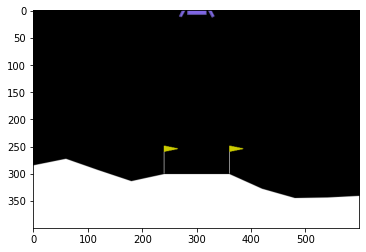

In [ ]:
env = gym.make(environment)
print(environment)
env.reset()
#action_size = env.action_space.n
#state_size = env.observation_space.shape[0]
print('Action Space-->',env.action_space)
print('Observation Space-->',env.observation_space)
print('reward range-->',env.reward_range)
print('Meta data --> ',env.metadata)
print('Specifications -->',env.spec)
# set seed
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
try :
  for i in range(200):
      env.render()
      action = env.action_space.sample()
      obs, reward, done, info = env.step(action)
      if done:
          env.reset()
except :
  pass
        
env.close()

In [ ]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim=-1) #-1 to take softmax of last dimension
    
class ValueFunctionNet(nn.Module):
    def __init__(self, state_size, hidden_size):
        super(ValueFunctionNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

In [ ]:
class PGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, vf_lr, discount ):
        self.action_size = action_size
        self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
        self.vf_net = ValueFunctionNet(state_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=actor_lr)
        self.vf_optimizer = optim.Adam(self.vf_net.parameters(), lr=vf_lr)
        self.discount = discount
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.actor_net(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action_probs = action_probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=action_probs)
        return action

    def train(self, state_list, action_list, reward_list):
        
        #turn rewards into return
        trajectory_len = len(reward_list)
        return_array = np.zeros((trajectory_len,))
        g_return = 0.
        if r2go == 'r2go':
          for i in range(trajectory_len-1,-1,-1):
              g_return = reward_list[i] + self.discount*g_return
              
              return_array[i] = g_return
        elif r2go == 'None' :
          for i in range(trajectory_len):
            return_array = reward_list[i] + self.discount*g_return

            
        # create tensors
        state_t = torch.FloatTensor(state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1,1)
        return_t = torch.FloatTensor(return_array).to(device).view(-1,1)
        
        # get value function estimates
        vf_t = self.vf_net(state_t).to(device)
        with torch.no_grad():
            advantage_t = return_t - vf_t
            if adv_norm == 'adv_norm':
              advantage_t = (advantage_t - np.mean(advantage_t)) / (np.std(advantage_t) + 1e-10) #Advantage normalization
        
        # calculate actor loss
        selected_action_prob = self.actor_net(state_t).gather(1, action_t)
        # REINFORCE loss:
        #actor_loss = torch.mean(-torch.log(selected_action_prob) * return_t)
        # REINFORCE Baseline loss:
        actor_loss = torch.mean(-torch.log(selected_action_prob) * advantage_t)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step() 

        # calculate vf loss
        loss_fn = nn.MSELoss()
        vf_loss = loss_fn(vf_t, return_t)
        self.vf_optimizer.zero_grad()
        vf_loss.backward()
        self.vf_optimizer.step() 
        
        return actor_loss.detach().cpu().numpy(), vf_loss.detach().cpu().numpy()

In [ ]:
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = num_iterations#5000 # run agent for this many episodes # USER INPUT 
hidden_size = 256 # number of units in NN hidden layers
actor_lr = 0.002 # learning rate for actor
value_function_lr = 0.002 # learning rate for value function
discount = 0.99 # discount factor gamma value
reward_scale = 0.01 #scale reward by this amount

# create agent
agent = PGAgent(state_size, action_size, hidden_size, actor_lr, value_function_lr, discount)

/usr/local/lib/python3.7/dist-packages/gym/core.py:257: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


In [ ]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_vf_loss = 0., 0.

for ep in range(episodes):
    state = env.reset()
    state_list, action_list, reward_list = [], [], []
    
    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)
        
        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward*reward_scale)
        
        # end episode early
        if total_reward < -250:
            done = 1
        
        if done:
            actor_loss, vf_loss = agent.train(state_list, action_list, reward_list)
            stats_rewards_list.append((ep, total_reward, episode_length))
            stats_actor_loss += actor_loss
            stats_vf_loss += vf_loss
            total_reward = 0
            episode_length = 0  
            if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(stats_actor_loss/stats_every), 
                    'VF Loss: {:.4f}'.format(stats_vf_loss/stats_every))
                stats_actor_loss, stats_vf_loss = 0., 0.
            break
        
        state = next_state

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Episode: 0 Timestep: 63 Total reward: -112.4 Episode length: 63.0 Actor Loss: -0.0900 VF Loss: 0.0445
Episode: 10 Timestep: 1152 Total reward: -256.0 Episode length: 108.9 Actor Loss: -0.0436 VF Loss: 0.3049
Episode: 20 Timestep: 1834 Total reward: -239.2 Episode length: 68.2 Actor Loss: -0.1324 VF Loss: 0.1701
Episode: 30 Timestep: 2464 Total reward: -275.0 Episode length: 63.0 Actor Loss: 0.0707 VF Loss: 0.2839
Episode: 40 Timestep: 3081 Total reward: -273.6 Episode length: 61.7 Actor Loss: -0.1857 VF Loss: 0.2049
Episode: 50 Timestep: 3756 Total reward: -263.0 Episode length: 67.5 Actor Loss: 0.0008 VF Loss: 0.1966
Episode: 60 Timestep: 4462 Total reward: -232.7 Episode length: 70.6 Actor Loss: 0.1565 VF Loss: 0.1908
Episode: 70 Timestep: 5196 Total reward: -185.6 Episode length: 73.4 Actor Loss: 0.0150 VF Loss: 0.3636
Episode: 80 Timestep: 5968 Total reward: -114.2 Episode length: 77.2 Actor Loss: 0.0099 VF Loss: 0.3255
Episode: 90 Timestep: 6732 Total reward: -150.2 Episode length

Text(0, 0.5, 'Episode Reward')

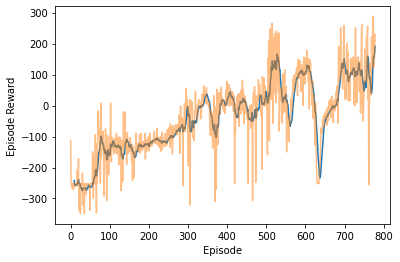

In [ ]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

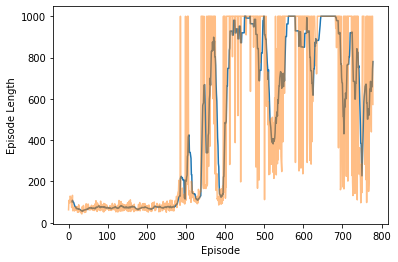

In [ ]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')